In [1]:
using Turing, Distributions, Gadfly, DataFrames

    +(AbstractArray, DataArrays.DataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


In [ ]:
include("/Users/kai/Turing/Turing.jl/notebooks/big-hmm.jl")

> Note on experiment:
- Experiments are done with SMC because the replaying version of PG is probalmatic in Truing.
- Experiments are done with 150 particles, simply because I can't run more in Probablistic C.
- Use replaying version by changing `TraceC` to `TraceR` in `smc.jl`

Define a helper function to collection counts from `Profile`.

In [2]:
function gen_counts()
    f = open("/Users/kai/temp/prof.txt","w")
    Profile.print(f, format=:flat)
    close(f)

    f = open("/Users/kai/temp/profdepth0.txt","w")
    Profile.print(f, maxdepth=0)
    close(f)
    
    fork_count = 0
    total_count = 0

    f = open("/Users/kai/temp/prof.txt")
    for ln in eachline(f)
        if contains(ln, "fork") fork_count += parse(Int, ln[1:6]) end
    end
    close(f)

    f = open("/Users/kai/temp/profdepth0.txt")
    for ln in eachline(f)
        if ln[2] != 'C' total_count += parse(Int, ln[1:3]) end
    end
    close(f)

    return fork_count, total_count
end
;

Profile steps
1. Change the copying method in the source code
2. Run the block below
3. Copy the counting output to the next block

In [3]:
forks = []
totals = []

for _ = 1:10
    Profile.init(delay=0.01)
    Profile.clear()
    @profile (for i = 1:10; sample(big_hmm, SMC(150)); end)
    fork_count, total_count = gen_counts()
    push!(forks, fork_count)
    push!(totals, total_count)
end

print(forks)
print(totals)
;

Any[6,3,10,7,3,3,1,4,3,3]Any[328,126,124,123,118,119,191,134,116,127]

All pre-generated counts are loaded/defined below.

In [2]:
forks_process = []
for i = 1:10
    df = readtable("./exp1/probc/fork$i.csv", separator = ',', header = false)
    push!(forks_process, sum([df[1,i] for i = 1:(length(df[1,:])-1)]))
end
totals_process = [17300,18811,18104,17864,18827,18051,18474,18355,18170,15699]

forks_coroutine= [6,3,10,7,3,3,1,4,3,3]
totals_coroutine= [328,126,124,123,118,119,191,134,116,127]

forks_replaying= [8,5,4,7,6,9,6,9,5,4]
totals_replaying= [138,162,136,142,128,199,146,120,125,123]
;

Creating stats for plotting.

In [3]:
fracs_process = [Float64(forks_process[i] / totals_process[i]) for i = 1:10]
fracs_replaying = [Float64(forks_replaying[i] / totals_replaying[i]) for i = 1:10]
fracs_coroutine = [Float64(forks_coroutine[i] / totals_coroutine[i]) for i = 1:10]

means_process = mean(fracs_process)
means_replaying = mean(fracs_replaying)
means_coruntine = mean(fracs_coroutine)

stds_process = std(fracs_process)
stds_replaying = std(fracs_replaying)
stds_coruntine = std(fracs_coroutine)

mins_process = means_process - (1.96 * stds_process / sqrt(10))
mins_replaying = means_replaying - (1.96 * stds_replaying / sqrt(10))
mins_coruntine = means_coruntine - (1.96 * stds_coruntine / sqrt(10))

maxs_process = means_process + (1.96 * stds_process / sqrt(10))
maxs_replaying = means_replaying + (1.96 * stds_replaying / sqrt(10))
maxs_coruntine = means_coruntine + (1.96 * stds_coruntine / sqrt(10))
;

Make plot.

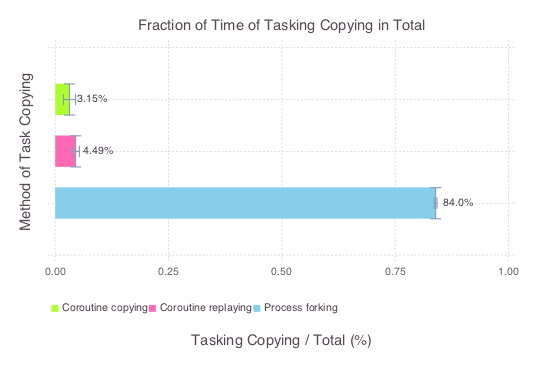

In [5]:
layer_errorbar = layer(
    ymax = [1, 2, 3] .+ 0.3, ymin = [1, 2, 3] .- 0.3,
    x = [means_process, means_replaying, means_coruntine],
    xmin = [mins_process, mins_replaying, mins_coruntine],
    xmax = [maxs_process, maxs_replaying, maxs_coruntine],
Geom.errorbar, Theme(default_color=colorant"lightsteelblue")
)

m_p = round(means_process, 2) * 100
m_r = round(means_replaying + 0.0001, 4) * 100 # 0.0001 is for correct presion showing in plot
m_c = round(means_coruntine, 4) * 100

layer_label = layer(
    y = [1, 2, 3],
    x = [means_process, means_replaying, means_coruntine],
label = ["$m_p%", "$m_r%", "$m_c%"], Geom.label(position=:right)
)

layer_process = layer(
    ymax = [1 + 0.3], ymin = [1 - 0.3], x = [means_process], 
    Geom.bar(orientation=:horizontal),
    Theme(default_color=colorant"skyblue")
)

layer_replaying = layer(
    ymax = [2 + 0.3], ymin = [2 - 0.3], x = [means_replaying], 
    Geom.bar(orientation=:horizontal),
    Theme(default_color=colorant"hotpink")
)

layer_coroutine = layer(
    ymax = [3 + 0.3], ymin = [3 - 0.3], x = [means_coruntine], 
    Geom.bar(orientation=:horizontal),
    Theme(default_color=colorant"greenyellow")
)

p = plot(
    layer_label,
    layer_errorbar,
    layer_coroutine, layer_replaying, layer_process,
    Stat.yticks(ticks=[0, 1, 2, 3, 4]),
    Stat.xticks(ticks=[0.00, 0.25, 0.50, 0.75, 1.00]),
Guide.manual_color_key("",["Coroutine copying","Coroutine replaying", "Process forking"], ["greenyellow", "hotpink", "skyblue"]),
Theme(key_position=:bottom),
    Guide.yticks(label=false),
    Guide.ylabel("Method of Task Copying"), 
    Guide.xlabel("Tasking Copying / Total (%)"),
    Guide.title("Fraction of Time of Tasking Copying in Total"),
    Coord.Cartesian(xmax=1.00)
)

Save plot to pdf.

In [6]:
draw(PDF("exp1.pdf", 5inch, 3.75inch), p)

> Environment:
- OS: macOS Sierra v10.12
- Machine: MacBook Pro (Retina, 13-inch, Late 2013)
- Processor: 2.4 GHz Intel Core i5
- Memory: 8 GB 16000 MHz DDR3
- Graphics:Intel Iris 1536 MB

> Note: number of cores used is limited to 1 for this experiment.